#### Based on https://github.com/rusty1s/pytorch_geometric/blob/master/examples/gat.py

In [1]:
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv

import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

init_notebook_mode(connected = True)

In [2]:
SEED = 42

# Fixing the random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
dataset = 'Cora'
path = os.path.join("data", dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

In [4]:
class Net(torch.nn.Module):
    def __init__(self, dropout_p=0.6):
        super(Net, self).__init__()
        
        self.dropout_p = dropout_p
        self.conv1 = GATConv(dataset.num_features, 8, heads=8, dropout=dropout_p)
        self.conv2 = GATConv(8 * 8, 8, heads=6, concat=True, dropout=dropout_p)
        self.classifier = nn.Linear(48, dataset.num_classes)
        
    def extract_features(self, x, edge_index, return_attention_weights=True):
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return self.conv2(x, edge_index, return_attention_weights=return_attention_weights)
    
    def forward(self, x, edge_index):
        features, _ = self.extract_features(x, edge_index)
        x = self.classifier(features)
        return F.log_softmax(x, dim=-1)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [6]:
model

Net(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 8, heads=6)
  (classifier): Linear(in_features=48, out_features=7, bias=True)
)

In [7]:
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = out[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


In [8]:
for epoch in range(1, 101):
    train(data)
    if epoch % 20 == 0:
        train_acc, val_acc, test_acc = test(data)
        print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
              f'Test: {test_acc:.4f}')

Epoch: 020, Train: 0.8071, Val: 0.6680, Test: 0.6570
Epoch: 040, Train: 0.9357, Val: 0.7620, Test: 0.7740
Epoch: 060, Train: 0.9929, Val: 0.7860, Test: 0.7930
Epoch: 080, Train: 0.9929, Val: 0.7900, Test: 0.8020
Epoch: 100, Train: 1.0000, Val: 0.7800, Test: 0.7970


In [9]:
model.eval()
features, a_weights = model.extract_features(data.x, data.edge_index, return_attention_weights=True)
features = features.detach().numpy()

In [10]:
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt

In [11]:
tsne = TSNE(n_components=2, random_state=SEED)
features_sub = tsne.fit_transform(features)

In [12]:
edge_indices, weights = a_weights
edge_indices.shape, weights.shape

(torch.Size([2, 13264]), torch.Size([13264, 6]))

In [13]:
weights_sum = weights.sum(axis=1)
weights_mean = weights.mean(axis=1)

In [14]:
# Filtering the self-loops
edge_indices = edge_indices.T[:-data.num_nodes]
weights_sum = weights_sum[:-data.num_nodes]
weights_mean = weights_mean[:-data.num_nodes]
edge_indices.shape, weights.shape

(torch.Size([10556, 2]), torch.Size([13264, 6]))

In [15]:
# Node_ids bigger than 1708 are for the testing.
result_edge_mask = (edge_indices >= 1708).sum(1) == 2
result_edges_filtered = edge_indices[result_edge_mask]
weights_sum_filtered = weights_sum[result_edge_mask]
weights_mean_filtered = weights_mean[result_edge_mask]

In [16]:
edge_plots = []
for edge, weight_sum, weight_mean in zip(result_edges_filtered.numpy(), 
                                         weights_sum_filtered.detach().numpy(), 
                                         weights_mean.detach().numpy()):
    source_id, target_id = edge
    source, target = features_sub[source_id], features_sub[target_id]
    x_data = [source[0], target[0]]
    y_data = [source[1], target[1]]
    edge_plots.append(
        go.Scatter(mode="lines", x=x_data, y=y_data, opacity=weight_mean,
                   line=dict(width=weight_sum, color="Gray"), 
                   showlegend=False)
    )

In [17]:
res_labels = model(data.x, data.edge_index).max(1)[1].numpy()

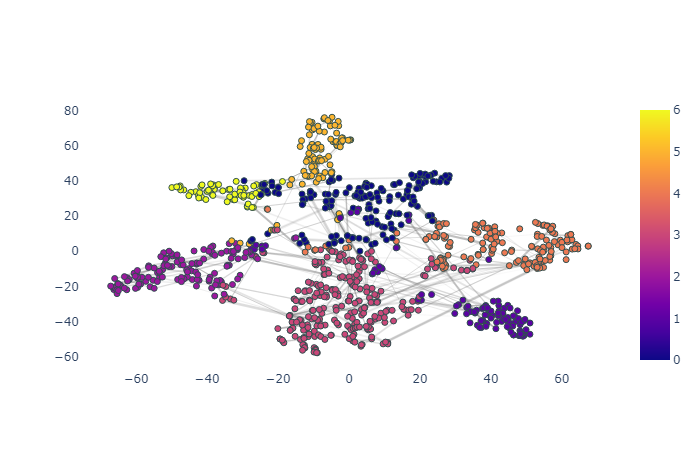

In [18]:
layout = go.Layout(
    plot_bgcolor='rgb(255, 255, 255)',
    paper_bgcolor='rgb(255, 255, 255)'
)

fig1 = px.scatter(x=features_sub[data.test_mask][:, 0], y=features_sub[data.test_mask][:, 1], 
                  color=res_labels[data.test_mask])
fig1.update_traces(marker=dict(size=6, line=dict(width=1, color="DarkSlateGrey")))
fig = go.Figure(data=edge_plots + list(fig1.data), layout=layout)
fig.show("png")